In [1]:
import gmsh
import meshio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%config InlineBackend.figure_format = "retina"

Info    : Meshing 1D...
Info    : Meshing curve 1 (Circle)
Info    : Done meshing 1D (Wall 0.00011075s, CPU 0.000126s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00475879s, CPU 0.004587s)
Info    : 84 nodes 167 elements
Info    : Writing 'hector_mine_basal.msh'...
Info    : Done writing 'hector_mine_basal.msh'



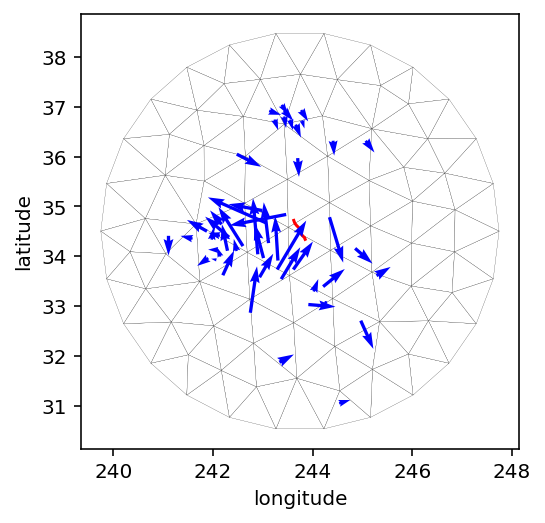

In [2]:
MESH_FILE_NAME = "hector_mine_basal.msh"
GPS_FILE_NAME = "hector_mine_postseismic_gps_freed_burgman_herring.csv"
FAULT_TRACE_FILE_NAME = "hector_mine_fault_trace_from_cfm.csv"

# Read GPS
df_gps = pd.read_csv(GPS_FILE_NAME)

# Remove stations that clearly have longitude reported as northvelocity
df_gps = df_gps[df_gps.north > -100]

# Remove nearfield stations flagged with a trailing asterisk in the original paper
df_gps = df_gps[~df_gps.name.str.contains("\*")]
df_gps.lon = df_gps.lon + 360

# Read fault trace
df_fault = pd.read_csv(FAULT_TRACE_FILE_NAME)
df_fault.lon = df_fault.lon + 360

# Create inital circular mesh
gmsh.initialize()
# Specify x, y, z, radius as first four arguments
gmsh.model.occ.addCircle(0.0, 0.0, 0.0, 4.0, 1, angle1=0.0, angle2=2 * np.pi)
gmsh.model.occ.addCurveLoop([1], 1)
gmsh.model.occ.addPlaneSurface([1], 1)
gmsh.model.occ.synchronize()
# Set the mesh size by changing the 10 (same units as the x, y, z, radius)
gmsh.model.mesh.setSize([(0, 1)], 1)
gmsh.model.mesh.generate(2)
gmsh.write(MESH_FILE_NAME)
gmsh.finalize()

# Read mesh
mesh = meshio.read(MESH_FILE_NAME)
n_tri = mesh.get_cells_type("triangle").shape[0]

# Move mesh to to be centered on the fault
mesh.points[mesh.get_cells_type("triangle")[:, :], 0] += df_fault.lon.mean()
mesh.points[mesh.get_cells_type("triangle")[:, :], 1] += df_fault.lat.mean()

# JPL style slight tilt of z-cordinates
base_depth = 30.0
depth_gradient = 0.000001
mesh.points[mesh.get_cells_type("triangle")[:, :], 2] = base_depth + depth_gradient * (
    mesh.points[mesh.get_cells_type("triangle")[:, :], 0]
    - mesh.points[mesh.get_cells_type("triangle")[:, :], 0].min()
)

# Plot model geometry
plt.figure()
for i in range(0, n_tri):
    plt.fill(
        [
            mesh.points[mesh.get_cells_type("triangle")[:, 0], 0][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 1], 0][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 2], 0][i],
        ],
        [
            mesh.points[mesh.get_cells_type("triangle")[:, 0], 1][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 1], 1][i],
            mesh.points[mesh.get_cells_type("triangle")[:, 2], 1][i],
        ],
        "-k",
        facecolor="w",
        edgecolor="k",
        linewidth=0.1,
    )

plt.plot(df_fault.lon, df_fault.lat, "-r")
plt.quiver(df_gps.lon, df_gps.lat, df_gps.east, df_gps.north, color="blue", zorder=10)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.gca().set_aspect("equal")
plt.show()